In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
#load data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(
    root="~/torch_datasets", train=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root="~/torch_datasets", train=False, transform=transform)

In [5]:
print('Number of samples at test set:\t{}\nNumber of samples at train set:\t{}'.format(len(test_dataset), len(train_dataset)))

Number of samples at test set:	10000
Number of samples at train set:	50000


In [6]:
#split training dataset for training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set = random_split(train_dataset, (train_size, val_size))

In [7]:
#make 3 loaders for training, validating and testing
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False)

In [8]:
#save labels names
classes = train_loader.dataset.dataset.classes

In [9]:
#data shape check
for img, lab in train_loader:
    print(img.shape)
    break

torch.Size([128, 3, 32, 32])


In [10]:
#show images from first batch
from torchvision.utils import make_grid

def show_batch(data_loader):
    for img, lab in data_loader:
        fig, ax = plt.subplots(figsize=(20,20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(img, 10).permute(1,2,0))
        break

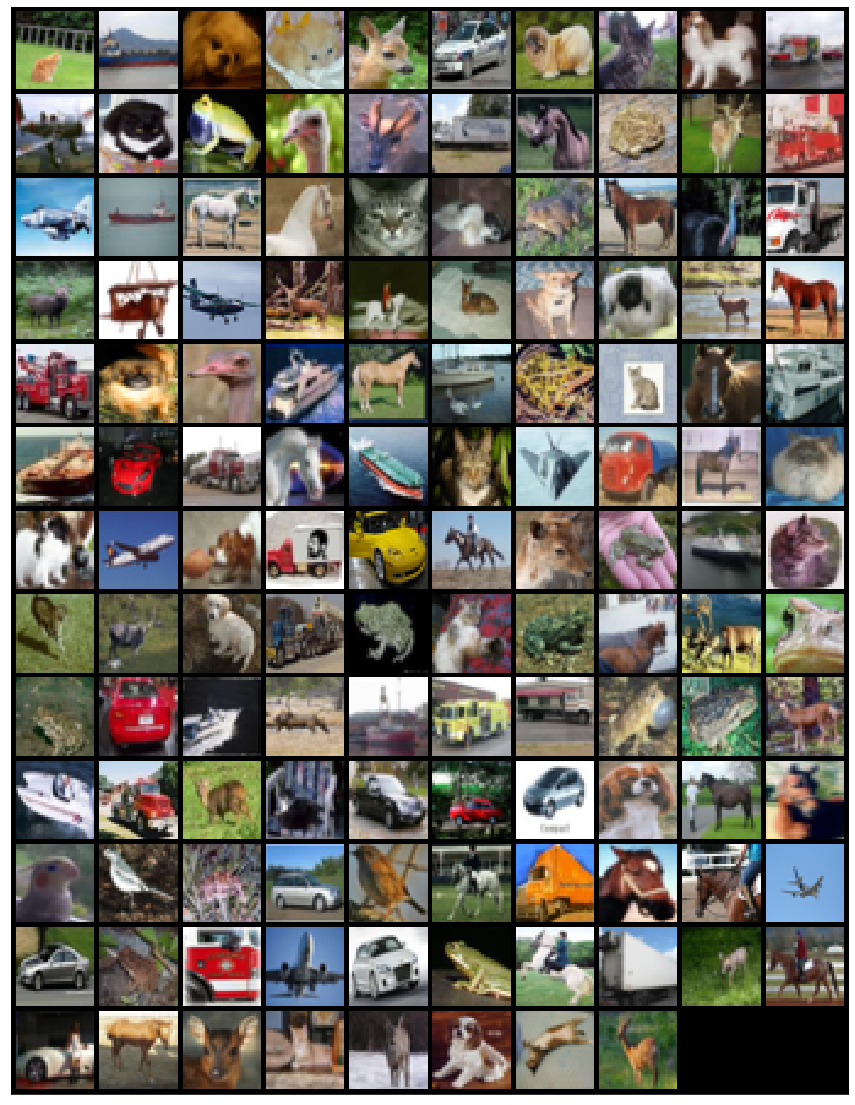

In [11]:
show_batch(train_loader)

In [12]:
#print info about model's layers
model = torchvision.models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
#adjustments for model proper work
model.fc = nn.Sequential(
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(128, 10),
                        nn.LogSoftmax(dim=1))

In [14]:
#set training params
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

In [15]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20):
    val_accuracy_list = []
    train_loss_list = []
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
       
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(output, dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        
        val_accuracy_list.append(num_correct/num_examples)
        train_loss_list.append(training_loss)
        
        print('Epoch: {:2d}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
    return val_accuracy_list, train_loss_list

In [16]:
#execute train function
acc, loss = train(model, optimizer, loss_fn, train_loader, val_loader, epochs=epochs)

Epoch:  0, Training Loss: 1.69, Validation Loss: 1.59, accuracy = 0.45
Epoch:  1, Training Loss: 1.34, Validation Loss: 1.40, accuracy = 0.50
Epoch:  2, Training Loss: 1.13, Validation Loss: 1.29, accuracy = 0.54
Epoch:  3, Training Loss: 0.98, Validation Loss: 1.44, accuracy = 0.54
Epoch:  4, Training Loss: 0.85, Validation Loss: 0.94, accuracy = 0.68
Epoch:  5, Training Loss: 0.75, Validation Loss: 1.25, accuracy = 0.62
Epoch:  6, Training Loss: 0.66, Validation Loss: 0.92, accuracy = 0.69
Epoch:  7, Training Loss: 0.57, Validation Loss: 1.05, accuracy = 0.70
Epoch:  8, Training Loss: 0.49, Validation Loss: 1.34, accuracy = 0.64
Epoch:  9, Training Loss: 0.42, Validation Loss: 1.01, accuracy = 0.70
Epoch: 10, Training Loss: 0.36, Validation Loss: 1.01, accuracy = 0.72
Epoch: 11, Training Loss: 0.30, Validation Loss: 1.08, accuracy = 0.71
Epoch: 12, Training Loss: 0.26, Validation Loss: 1.16, accuracy = 0.73
Epoch: 13, Training Loss: 0.22, Validation Loss: 1.12, accuracy = 0.73
Epoch:

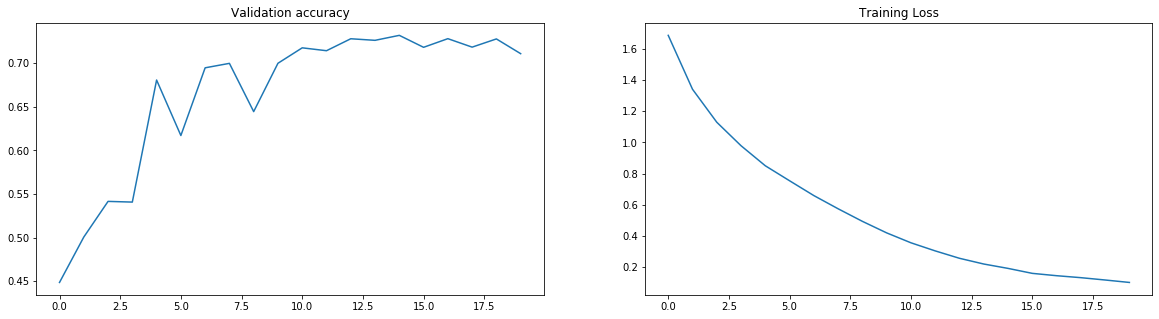

In [17]:
#make two plots: validation accuracy and training loss
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(range(len(acc)), acc)
ax[0].set_title('Validation accuracy')
ax[1].plot(range(len(loss)), loss)
ax[1].set_title('Training Loss')
plt.show()

In [18]:
#compute model's accuracy at testing data
with torch.no_grad():
    num_correct = 0
    num_examples = 0
    for img, lb in test_loader:
        output = model(img)
        correct = torch.eq(torch.max(output, dim=1)[1], lb).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    print(f'Accuracy of the model for test dataset: {num_correct*100/num_examples}%')

Accuracy of the model for test dataset: 71.94%


In [19]:
#get predicted label name
def predicted_label_name(out):
    pred = (out == out.max()).nonzero()
    return classes[pred[0,1].item()]

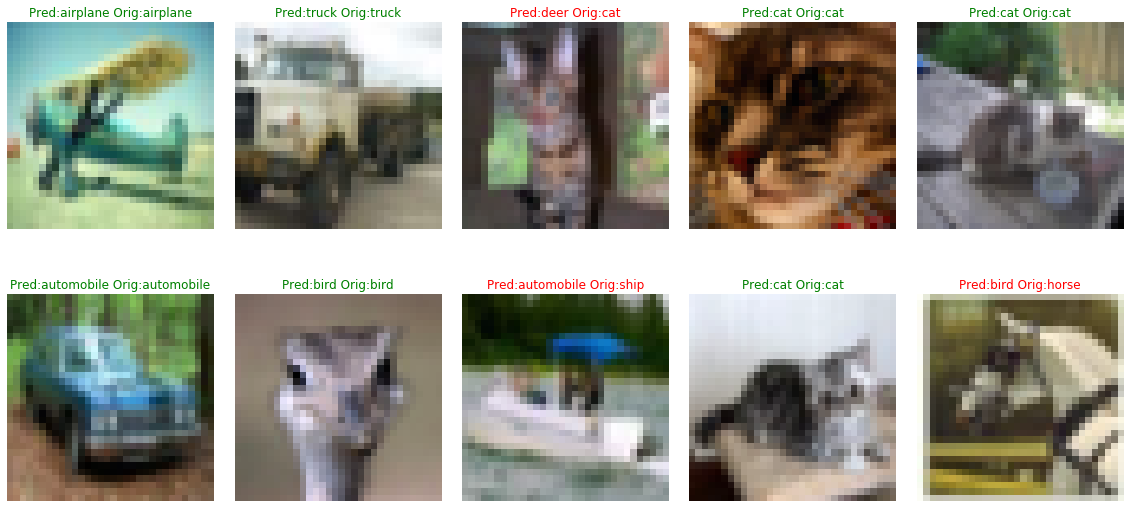

In [20]:
#show 10 randomly picked images to see if they are predicted well
with torch.no_grad():    
    fig, ax = plt.subplots(2, 5, figsize = (20, 10))
    for i in range(5):
        a = random.randint(0, len(test_dataset))
        b = random.randint(0, len(test_dataset))
        out_a = model(test_dataset[a][0].unsqueeze(0))
        out_b = model(test_dataset[b][0].unsqueeze(0))    
        ax[0][i].imshow((test_dataset[a][0]/test_dataset[a][0].max()).permute(1,2,0))
        if predicted_label_name(out_a) == classes[test_dataset[a][1]]:
            color = 'green'
        else:
            color = 'red'
        ax[0][i].set_title('Pred:' + predicted_label_name(out_a) + ' Orig:' + classes[test_dataset[a][1]], color=color)
        ax[0][i].set_axis_off()
        ax[1][i].imshow((test_dataset[b][0]/test_dataset[b][0].max()).permute(1,2,0))
        if predicted_label_name(out_b) == classes[test_dataset[b][1]]:
            color = 'green'
        else:
            color = 'red'
        ax[1][i].set_title('Pred:' + predicted_label_name(out_b) + ' Orig:' + classes[test_dataset[b][1]], color=color)
        ax[1][i].set_axis_off()
        plt.subplots_adjust(wspace = 0.1, hspace = 0)

In [21]:
#check accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of {}:\t{:.0f}%'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane:	84%
Accuracy of automobile:	85%
Accuracy of bird:	77%
Accuracy of cat:	53%
Accuracy of deer:	55%
Accuracy of dog:	50%
Accuracy of frog:	83%
Accuracy of horse:	67%
Accuracy of ship:	88%
Accuracy of truck:	78%
